<a href="https://colab.research.google.com/github/ReinkeSven/claims_simulations/blob/master/Claims_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Simulation

In the following I create a small class that creates a Monte Carlo based claims
simulation for claims.




In [370]:
import numpy as np
import math
import matplotlib.pyplot as plt
#np.set_printoptions(precision=15)

class MonteCarloClaims():
  """
  This class generates a claims distribution based on a frequency and severity distribution.
  The methodolody follows the theory of Parodi, P - Pricing in General Insurance, Chapter 17.4 
  "Monte Carlo Simulation."
  """

  def __init__(self, num_sims, seed):
    self._seed = seed
    if num_sims <=0:
      raise ValueError("Number of simulations must be bigger 0.")
    elif not isinstance(num_sims, int):
      raise TypeError("Number of simulations must be integer.")
    else:
      self.num_sims = num_sims

  @property
  def seed(self):
    return self._seed
  
  @property
  def poi_param(self):
    return self._poi_param
  
  def poison_claim_count(self, poi_param):
    """
    Generate a poisson-distributed claims count
    """
    np.random.seed(self._seed)
    self._poi_param = poi_param
    self.poi_dist = np.random.poisson(poi_param, self.num_sims)

  @property
  def gamma_shape(self):
    return self._gamma_shape

  @property
  def gamma_scale(self):
    return self._gamma_scale
  
  @property
  def gamma_clms(self):
    return self._gamma_clms

  def gamma_severity(self, shape, scale):
    np.random.seed(self._seed)
    self._gamma_shape = shape
    self._gamma_scale = scale
    
    gamma_pdf = lambda x : np.random.gamma(self._gamma_shape, self._gamma_scale, x)
    try:
      self._gamma_clms = np.hstack(np.array([gamma_pdf(x) for x in self.poi_dist]))
    except AttributeError:
      print("Error - Need to initialize claims count first.")
  
  def gamma_value_at_risk(self, percentile):
    srtd_claims = np.sort(self._gamma_clms)
    num_thres = math.floor((1-percentile/100)*self.num_sims)
    return srtd_claims[-num_thres]

  def gamma_cond_value_at_risk(self, percentile):
    srtd_claims = np.sort(self._gamma_clms)
    num_thres = math.floor((1-percentile/100)*self.num_sims)
    return srtd_claims[-num_thres:].mean()

  def apply_deductible(self, value):
    if value>=0:
      clms = np.copy(self._gamma_clms)
      clms_sum = clms.sum()
      clms_ded = clms - value # substract deductible from each claims.
      clms_ded_sum = clms_ded[clms_ded>0].sum()
      print(clms_ded)
      print(f'The deductible eliminates {(1-clms_ded_sum/clms_sum)*100:.2f} percent of the loss amounts.')
      print(f"Average severity before deductible {clms.mean():.4f}.")
      print(f"Average severity after deductible {clms_ded.mean():.4f}.")
      return clms_ded[clms_ded>0]
    else:
      raise ValueError('Deductible must be bigger 0.')

  def apply_limit(self, value):
    if value>0:
      clms = np.copy(self._gamma_clms)
      clms_sum = clms.sum()
      clms_lim = np.minimum(clms, value) # Apply limit.
      clms_lim_sum = clms_lim.sum()
      print(clms_lim)
      print(f'The limit eliminates {(1-clms_lim_sum/clms_sum)*100:.2f} percent of the loss amounts.')
      print(f"Average severity before deductible {clms.mean():.4f}.")
      print(f"Average severity after deductible {clms_lim.mean():.4f}.")
      return clms_lim
    else:
      raise ValueError('Limit must be bigger 0.')
  
  def apply_deductible_limit(self, ded=0, limit=np.Inf):
    if (ded>=0) & (limit>=0):
      clms = np.copy(self._gamma_clms)
      clms_sum = clms.sum()
      clms_lim_ded = np.minimum(clms, limit)-ded
      clms_lim_ded = clms_lim_ded[clms_lim_ded>0] # Apply limit.
      clms_lim_ded_sum = clms_lim_ded.sum()
      print(f'The deductible/limit combination eliminates {(1-clms_lim_ded_sum/clms_sum)*100:.2f} percent of the loss.')
      print(f"Average severity before deductible {clms.mean():.4f}.")
      print(f"Average severity after deductible {clms_lim_ded.mean():.4f}.")
      return clms_lim_ded
    else:
      raise ValueError('Ded/Limit must be greater of equal 0.')


In [371]:
#instantiate Claims distribution object with 10000 simulations and a seed of 42
Claims = MonteCarloClaims(10000, 42)

In [372]:
Claims.seed

42

In [373]:
# simulate number of claims
Claims.poison_claim_count(1.2)

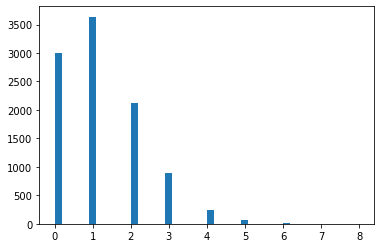

In [374]:
_ = plt.hist(Claims.poi_dist, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [375]:
print(Claims.poi_dist.mean()) #gives back input value.

1.2025


In [376]:
# for each claim simulate an amount taken from a gamma distribution.
Claims.gamma_severity(7.5, 1)

In [377]:
Claims.gamma_clms

array([ 8.58033893,  6.80286018,  6.55792163, ...,  8.51571326,
       10.21500101, 10.07860159])

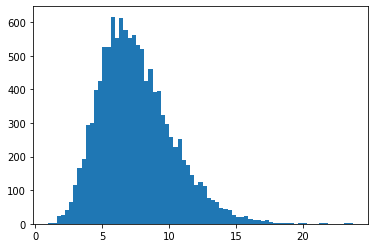

In [378]:
_ = plt.hist(Claims.gamma_clms, bins="auto")

In [379]:
# apply a deductible of 5
Claims.apply_deductible(5)

[3.58033893 1.80286018 1.55792163 ... 3.51571326 5.21500101 5.07860159]
The deductible eliminates 64.07 percent of the loss amounts.
Average severity before deductible 7.5481.
Average severity after deductible 2.5481.


array([3.58033893, 1.80286018, 1.55792163, ..., 3.51571326, 5.21500101,
       5.07860159])

[3.58033893 1.80286018 1.55792163 ... 3.51571326 5.21500101 5.07860159]
The deductible eliminates 64.07 percent of the loss amounts.
Average severity before deductible 7.5481.
Average severity after deductible 2.5481.


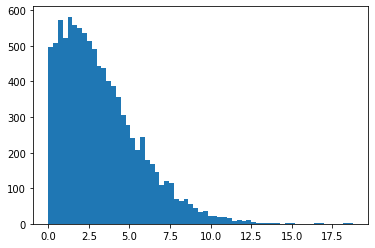

In [380]:
_ = plt.hist(Claims.apply_deductible(5), bins="auto")

In [381]:
Claims.apply_limit(8)

[8.         6.80286018 6.55792163 ... 8.         8.         8.        ]
The limit eliminates 11.78 percent of the loss amounts.
Average severity before deductible 7.5481.
Average severity after deductible 6.6591.


array([8.        , 6.80286018, 6.55792163, ..., 8.        , 8.        ,
       8.        ])

[8.         6.80286018 6.55792163 ... 8.         8.         8.        ]
The limit eliminates 11.78 percent of the loss amounts.
Average severity before deductible 7.5481.
Average severity after deductible 6.6591.


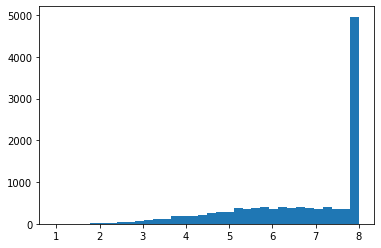

In [382]:
_ = plt.hist(Claims.apply_limit(8), bins="auto")

In [383]:
ded_lim_claims = Claims.apply_deductible_limit(5, 8)

The deductible/limit combination eliminates 75.84 percent of the loss.
Average severity before deductible 7.5481.
Average severity after deductible 2.1925.


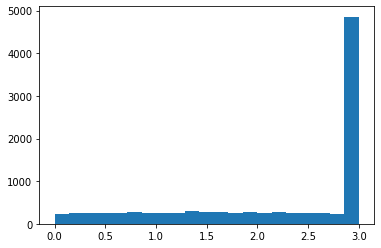

In [385]:
_ = plt.hist(ded_lim_claims, bins='auto')  # arguments are passed to np.histogram